<a href="https://colab.research.google.com/github/diqksrk/hanghaeAI2/blob/main/2weekhomework1modi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [전체 코드]

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch import nn
from math import sqrt
from torch.optim import Adam
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from matplotlib import pyplot as plt

device = torch.device("mps")

ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)

max_len = 400
print(positional_encoding(max_len, 256).shape)

class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff,  num_classes):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, num_classes)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x

num_classes = len(tokenizer)
model = TextClassifier(len(tokenizer), 32, 2, 32, num_classes)

lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


n_epochs = 50

train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device).float()

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

# Plotting function
def plot_acc(train_acc_list, test_acc_list, label1='train_acc', label2='test_acc'):
    x = np.arange(len(train_acc_list))

    plt.plot(x, train_acc_list, label=label1)
    plt.plot(x, test_acc_list, label=label2)
    plt.legend()
    plt.show()

plot_acc(train_acc_list, test_acc_list)

## [MyCode]
기존처럼 전체가 아닌 마지막 두번째 토큰을 추출하여 데이터셋과, 테스트셋을 구성하도록 환경을 수정합니다.

In [ ]:
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

## [MyCode]
토큰 id를 예측하는 즉 클래스를 예측하는 일반 분류 문제로 변경되었으므로, BCEWithLogitsLoss손실함수를 분류문제에 해당되는 CrossEntropyLoss 손실함수로 변경합니다. 그리고, 분류문제에 맞춰서 기존 출력차원을 조절 합니다.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff,  num_classes):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, num_classes)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x

num_classes = len(tokenizer)
model = TextClassifier(len(tokenizer), 32, 2, 32, num_classes)


## [MyCode]
정확도 함수에서 예측값을 torch.argmax를 사용하여 클래스 레이블로 변환합니다.
그리고 실행시켜봅니다.

In [ ]:
  def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      preds = model(inputs)
      // 해당 부분
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

    return acc / cnt

  for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
      model.zero_grad()
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device).float()

      preds = model(inputs)
      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

### [LOG]


Epoch   0 | Train Loss: 1501.4766647815704<br/>
=========> Train acc: 0.558 | Test acc: 0.564<br/>
Epoch   1 | Train Loss: 1159.8295937776566<br/>
=========> Train acc: 0.558 | Test acc: 0.564<br/>
Epoch   2 | Train Loss: 1116.2473225593567<br/>
=========> Train acc: 0.558 | Test acc: 0.563<br/>
Epoch   3 | Train Loss: 1085.6981757879257<br/>
=========> Train acc: 0.558 | Test acc: 0.563<br/>
Epoch   4 | Train Loss: 1062.4636808633804<br/>
=========> Train acc: 0.553 | Test acc: 0.554<br/>
Epoch   5 | Train Loss: 1050.7599549293518<br/>
=========> Train acc: 0.558 | Test acc: 0.562<br/>
Epoch   6 | Train Loss: 1041.6333692073822<br/>
=========> Train acc: 0.558 | Test acc: 0.561<br/>
Epoch   7 | Train Loss: 1036.0794154405594<br/>
=========> Train acc: 0.557 | Test acc: 0.560<br/>
Epoch   8 | Train Loss: 1030.0537340641022<br/>
=========> Train acc: 0.558 | Test acc: 0.563<br/>
Epoch   9 | Train Loss: 1024.275174498558<br/>
=========> Train acc: 0.558 | Test acc: 0.562<br/>
Epoch  10 | Train Loss: 1017.2010618448257<br/>
=========> Train acc: 0.559 | Test acc: 0.560<br/>
Epoch  11 | Train Loss: 1013.6572650671005<br/>
=========> Train acc: 0.560 | Test acc: 0.563<br/>
Epoch  12 | Train Loss: 1008.6274119615555<br/>
=========> Train acc: 0.558 | Test acc: 0.559<br/>
Epoch  13 | Train Loss: 995.6458511352539<br/>
=========> Train acc: 0.561 | Test acc: 0.563<br/>
Epoch  14 | Train Loss: 990.1279065608978<br/>
=========> Train acc: 0.561 | Test acc: 0.565<br/>
Epoch  15 | Train Loss: 986.0031441450119<br/>
=========> Train acc: 0.563 | Test acc: 0.565<br/>
Epoch  16 | Train Loss: 979.1073282957077<br/>
=========> Train acc: 0.562 | Test acc: 0.564<br/>
Epoch  17 | Train Loss: 973.7754743099213<br/>
=========> Train acc: 0.562 | Test acc: 0.561<br/>
Epoch  18 | Train Loss: 966.1164623498917<br/>
=========> Train acc: 0.563 | Test acc: 0.564<br/>
Epoch  19 | Train Loss: 963.6306411027908<br/>
=========> Train acc: 0.565 | Test acc: 0.566<br/>
Epoch  20 | Train Loss: 960.4852530956268<br/>
=========> Train acc: 0.564 | Test acc: 0.564<br/>
Epoch  21 | Train Loss: 954.5764465332031<br/>
=========> Train acc: 0.564 | Test acc: 0.561<br/>
Epoch  22 | Train Loss: 950.5888079404831<br/>
=========> Train acc: 0.565 | Test acc: 0.566<br/>
Epoch  23 | Train Loss: 946.5827482938766<br/>
=========> Train acc: 0.565 | Test acc: 0.560<br/>
Epoch  24 | Train Loss: 942.3223479986191<br/>
=========> Train acc: 0.564 | Test acc: 0.559<br/>
Epoch  25 | Train Loss: 938.426206946373<br/>
=========> Train acc: 0.563 | Test acc: 0.560<br/>
Epoch  26 | Train Loss: 939.0970855951309<br/>
=========> Train acc: 0.566 | Test acc: 0.562<br/>
Epoch  27 | Train Loss: 932.8033748865128<br/>
...<br/>
Epoch  38 | Train Loss: 888.8836308717728<br/>
=========> Train acc: 0.569 | Test acc: 0.559<br/>
Epoch  39 | Train Loss: 885.3300759792328<br/>
=========> Train acc: 0.574 | Test acc: 0.560<br/>
Epoch  40 | Train Loss: 880.1540688276291<br/>
=========> Train acc: 0.574 | Test acc: 0.564<br/>
Epoch  41 | Train Loss: 876.505773305893<br/>
=========> Train acc: 0.575 | Test acc: 0.563<br/>
Epoch  42 | Train Loss: 879.2086874246597<br/>
=========> Train acc: 0.571 | Test acc: 0.561<br/>
Epoch  43 | Train Loss: 872.8964203596115<br/>
=========> Train acc: 0.574 | Test acc: 0.560<br/>
Epoch  44 | Train Loss: 869.081885933876<br/>
=========> Train acc: 0.575 | Test acc: 0.559<br/>
Epoch  45 | Train Loss: 866.4102745056152<br/>
=========> Train acc: 0.574 | Test acc: 0.563<br/>
Epoch  46 | Train Loss: 864.2577744722366<br/>
=========> Train acc: 0.575 | Test acc: 0.558<br/>
Epoch  47 | Train Loss: 858.2273855209351<br/>
=========> Train acc: 0.576 | Test acc: 0.561<br/>
Epoch  48 | Train Loss: 855.3879095315933<br/>
=========> Train acc: 0.577 | Test acc: 0.562<br/>
Epoch  49 | Train Loss: 846.7116441726685<br/>
=========> Train acc: 0.574 | Test acc: 0.547<br/>
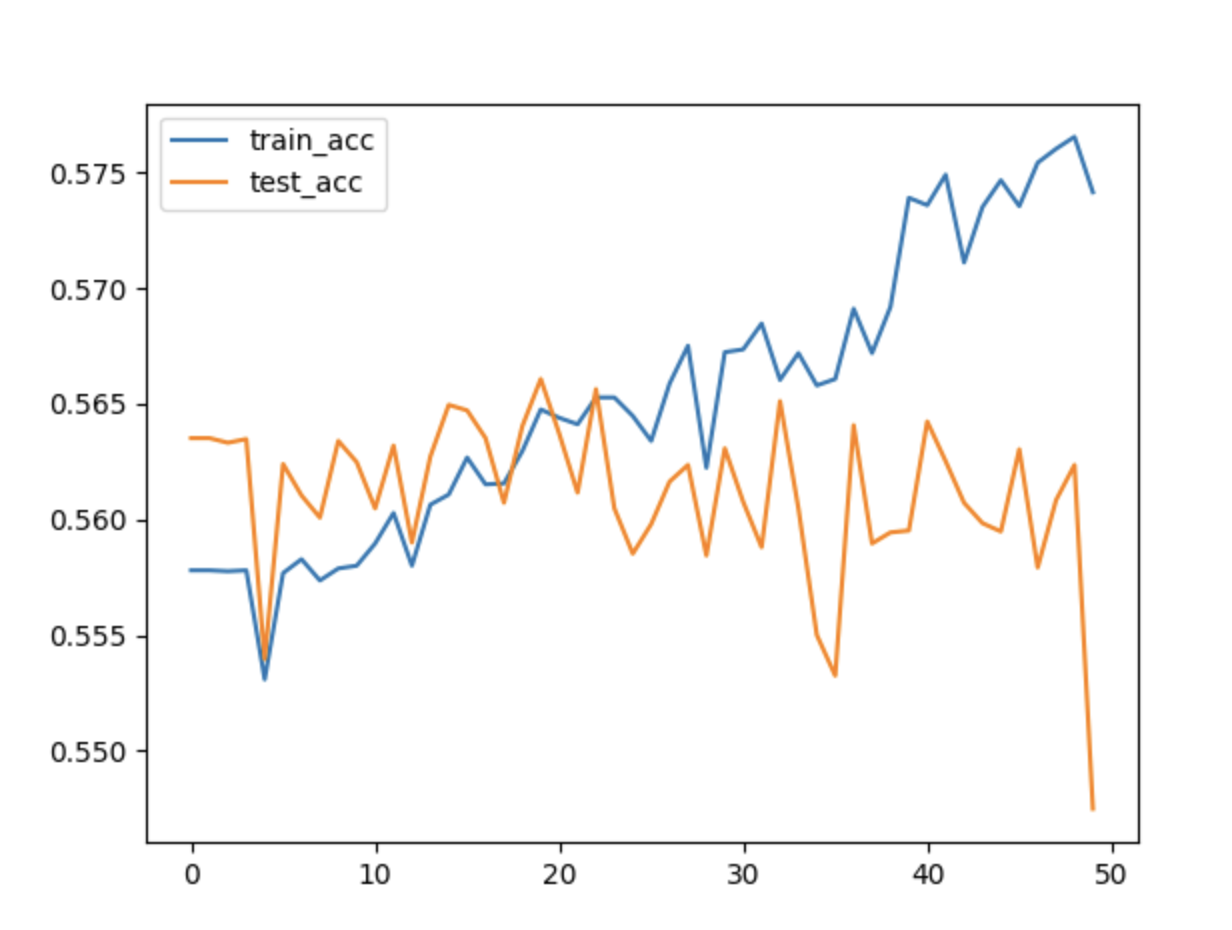

## [FEEDBACK] 1번
아래와 같은 포지션 인코딩 함수로 사인, 코싸인을 이용하는데 이걸 왜 이용하는지 ? 다른 방식이 있는지 궁금합니다. 예측하기로는 특정값의 범위를 벗어나지 않는 순환된 값을 위해서 사용한다 생각하는데 그러면 결국 값의 중복이 발생되지 않는지 싶어서요.

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)

## [FEEDBACK] 2번
로그를 보니, 로스는 줄지만 validation accuracy는 거의 변동 없는 모습을 확인했습니다. 결국 특정 토큰이 많이 나오다보니 학습 자체도 편항적으로 이루어지는것 같은데요. 해당 현상이 현업에서 자주 발생되는지 ? 해결하기 위해서는 무엇을 해야 하는지 궁금합니다.

Epoch   0 | Train Loss: 1501.4766647815704<br/>
=========> Train acc: 0.558 | Test acc: 0.564<br/>
Epoch   1 | Train Loss: 1159.8295937776566<br/>
=========> Train acc: 0.558 | Test acc: 0.564<br/>
Epoch   2 | Train Loss: 1116.2473225593567<br/>
=========> Train acc: 0.558 | Test acc: 0.563<br/>
Epoch   3 | Train Loss: 1085.6981757879257<br/>
=========> Train acc: 0.558 | Test acc: 0.563<br/>
Epoch   4 | Train Loss: 1062.4636808633804<br/>
=========> Train acc: 0.553 | Test acc: 0.554<br/>
Epoch   5 | Train Loss: 1050.7599549293518<br/>
=========> Train acc: 0.558 | Test acc: 0.562<br/>
Epoch   6 | Train Loss: 1041.6333692073822<br/>
=========> Train acc: 0.558 | Test acc: 0.561<br/>
Epoch   7 | Train Loss: 1036.0794154405594<br/>
=========> Train acc: 0.557 | Test acc: 0.560<br/>
Epoch   8 | Train Loss: 1030.0537340641022<br/>
=========> Train acc: 0.558 | Test acc: 0.563<br/>
Epoch   9 | Train Loss: 1024.275174498558<br/>
=========> Train acc: 0.558 | Test acc: 0.562<br/>
Epoch  10 | Train Loss: 1017.2010618448257<br/>
=========> Train acc: 0.559 | Test acc: 0.560<br/>
Epoch  11 | Train Loss: 1013.6572650671005<br/>
=========> Train acc: 0.560 | Test acc: 0.563<br/>
Epoch  12 | Train Loss: 1008.6274119615555<br/>
=========> Train acc: 0.558 | Test acc: 0.559<br/>
Epoch  13 | Train Loss: 995.6458511352539<br/>
=========> Train acc: 0.561 | Test acc: 0.563<br/>
Epoch  14 | Train Loss: 990.1279065608978<br/>
=========> Train acc: 0.561 | Test acc: 0.565<br/>
Epoch  15 | Train Loss: 986.0031441450119<br/>
=========> Train acc: 0.563 | Test acc: 0.565<br/>
Epoch  16 | Train Loss: 979.1073282957077<br/>
=========> Train acc: 0.562 | Test acc: 0.564<br/>
Epoch  17 | Train Loss: 973.7754743099213<br/>
=========> Train acc: 0.562 | Test acc: 0.561<br/>
Epoch  18 | Train Loss: 966.1164623498917<br/>
=========> Train acc: 0.563 | Test acc: 0.564<br/>
Epoch  19 | Train Loss: 963.6306411027908<br/>
=========> Train acc: 0.565 | Test acc: 0.566<br/>
Epoch  20 | Train Loss: 960.4852530956268<br/>
=========> Train acc: 0.564 | Test acc: 0.564<br/>
Epoch  21 | Train Loss: 954.5764465332031<br/>
=========> Train acc: 0.564 | Test acc: 0.561<br/>
Epoch  22 | Train Loss: 950.5888079404831<br/>
=========> Train acc: 0.565 | Test acc: 0.566<br/>
Epoch  23 | Train Loss: 946.5827482938766<br/>
=========> Train acc: 0.565 | Test acc: 0.560<br/>
Epoch  24 | Train Loss: 942.3223479986191<br/>
=========> Train acc: 0.564 | Test acc: 0.559<br/>
Epoch  25 | Train Loss: 938.426206946373<br/>
=========> Train acc: 0.563 | Test acc: 0.560<br/>
Epoch  26 | Train Loss: 939.0970855951309<br/>
=========> Train acc: 0.566 | Test acc: 0.562<br/>
Epoch  27 | Train Loss: 932.8033748865128<br/>
...<br/>
Epoch  38 | Train Loss: 888.8836308717728<br/>
=========> Train acc: 0.569 | Test acc: 0.559<br/>
Epoch  39 | Train Loss: 885.3300759792328<br/>
=========> Train acc: 0.574 | Test acc: 0.560<br/>
Epoch  40 | Train Loss: 880.1540688276291<br/>
=========> Train acc: 0.574 | Test acc: 0.564<br/>
Epoch  41 | Train Loss: 876.505773305893<br/>
=========> Train acc: 0.575 | Test acc: 0.563<br/>
Epoch  42 | Train Loss: 879.2086874246597<br/>
=========> Train acc: 0.571 | Test acc: 0.561<br/>
Epoch  43 | Train Loss: 872.8964203596115<br/>
=========> Train acc: 0.574 | Test acc: 0.560<br/>
Epoch  44 | Train Loss: 869.081885933876<br/>
=========> Train acc: 0.575 | Test acc: 0.559<br/>
Epoch  45 | Train Loss: 866.4102745056152<br/>
=========> Train acc: 0.574 | Test acc: 0.563<br/>
Epoch  46 | Train Loss: 864.2577744722366<br/>
=========> Train acc: 0.575 | Test acc: 0.558<br/>
Epoch  47 | Train Loss: 858.2273855209351<br/>
=========> Train acc: 0.576 | Test acc: 0.561<br/>
Epoch  48 | Train Loss: 855.3879095315933<br/>
=========> Train acc: 0.577 | Test acc: 0.562<br/>
Epoch  49 | Train Loss: 846.7116441726685<br/>
=========> Train acc: 0.574 | Test acc: 0.547<br/>